**NB: It is important to mention that i did not fix the seed.So running the code will make the obtained values different from the ones in the responses.**

# Skin lesion classification

**Deadline**: Upload this notebook (rename it as 'TP-SVM-YOUR-SURNAME.ipynb') to Ecampus before the deadline.


**Context**
A skin lesion is defined as a superficial growth or patch of the skin that is visually different and/or has a different texture than its surrounding area. Skin lesions, such as moles or birthmarks, can degenerate and become melanoma, one of the deadliest skin cancer. Its incidence has been increasing during the last decades, especially in the areas mostly populated by white people.

The most effective treatment is an early detection followed by surgical excision. This is why several approaches for melanoma detection have been proposed in the last years (non-invasive computer-aided diagnosis (CAD) ).


**Goal**
The goal of this practical session is to classify images of skin lesions as either benign or melanoma using machine learning algorithms. In order to do that, you will have at your disposal a set of 30 features already extracted from 600 dermoscopic images (both normal skin lesions and melanoma from the ISIC database - https://isic-archive.com/). These features characterize the Asymmetry, the Border irregularity, the Colour and the Dimension of the lesion (the so-called ABCD rule). 

The features are:
- shape asimmetry (f0 and f1)
- difference in colors between center and periphery of the image (f2, f3, f4, f27, f28, f29)
- geometry (f5, f6, f7)
- other features related to eccentricity,entropy, mean, standard deviation and maximum value of each channel in RGB and HSV (f8,...,f24)
- asimmetry of color intensity (f25, f26)

Features are computed using *manually checked segmentations* and following *Ganster et al. 'Automated melanoma recognition', IEEE TMI, 2001* and *Zortea et al. 'Performance of a dermoscopy-based computer vision system for the diagnosis of pigmented skin lesions compared with visual evaluation by experienced dermatologists', Artificial Intelligence in Medicine, 2014*.

First load all necessary packages

In [31]:
import os
import numpy as np
import pandas as pd
from skimage.io import imread
from time import time
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.model_selection import  cross_val_score
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import GridSearchCV, KFold, cross_validate
from sklearn.linear_model import Perceptron
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score

%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

# Code from scikit-learn
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


Then load the data from my Google Drive

In [32]:
from google_drive_downloader import GoogleDriveDownloader as gdd
gdd.download_file_from_google_drive(file_id='18hrQVGBCfW7SKTnzmWUONo8iowBsi1DL',
dest_path='./data/features.csv')
gdd.download_file_from_google_drive(file_id='1iQZdUiuK_FwZ7mik7LB3eN_H_IUc5l7b',
dest_path='./data/im/nevus-seg.jpg')
gdd.download_file_from_google_drive(file_id='1_TeYzLLDoKbPX4xXAOAM_mQiT2nLHgvp',
dest_path='./data/im/nevus.jpg')
gdd.download_file_from_google_drive(file_id='1B2Ol92mBcHN6ah3bpoucBbBbHkPMGC8D',
dest_path='./data/im/melanoma-seg.jpg')
gdd.download_file_from_google_drive(file_id='1yZ46UzGhwO7g5T8397JpewBl6UqgRo5J',
dest_path='./data/im/melanoma.jpg')

Or from yout local computer. Please download the 'data' folder in the same folder as your notebook and do not modifiy it.

Then read the data 

In [33]:
## Read data
Working_directory="./data/" 
df = pd.read_csv(Working_directory + 'features.csv') # reading data
y = df['Malignant'].values # 1 for Melanoma and 0 for healthy
class_names = ["healthy","melanoma"]
X = df.iloc[:,3:33].values # Features
N,M=X.shape
print('Number of images: {0}; Number of features per image: {1}'.format(N,M))
print('Number of healthy nevus: {0}; Number of melanoma: {1}'.format(N-np.sum(y), np.sum(y)))


Number of images: 600; Number of features per image: 30
Number of healthy nevus: 485; Number of melanoma: 115


Two examples of healthy nevus and melanoma


Text(0.5, 1.0, 'Segmented melanoma')

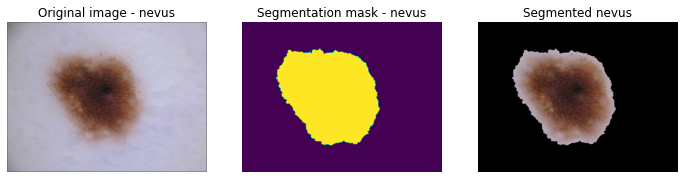

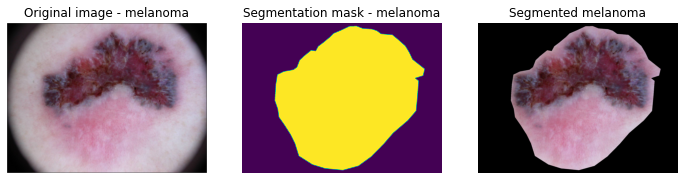

In [34]:
## Plot two examples of nevus and melanoma
print('Two examples of healthy nevus and melanoma')
nevus = imread(Working_directory + 'im/nevus.jpg')
nevus_Segmentation = imread(Working_directory + 'im/nevus-seg.jpg') 
nevus_Segmentation_boolean = (nevus_Segmentation/255).astype(np.uint8) # To get uint8 (integer numbers)
nevus_Segmentation_3D = np.expand_dims(nevus_Segmentation_boolean, axis=2) # To have a binary mask for the three channels (RGB)
nevus_mul_mask = (nevus_Segmentation_3D*nevus) # we apply the binary mask to all channels pixel-wise

fig = plt.figure(figsize=(12, 12)) # size of the figure
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 3),
                axes_pad = 0.5) # code to create subplots
grid[0].imshow(nevus)
grid[0].axis('off')
grid[0].set_title('Original image - nevus')
grid[1].imshow(nevus_Segmentation)
grid[1].axis('off')
grid[1].set_title("Segmentation mask - nevus")
grid[2].imshow(nevus_mul_mask)
grid[2].axis('off')
grid[2].set_title("Segmented nevus")

###

melanoma = imread(Working_directory + 'im/melanoma.jpg')
melanoma_Segmentation = imread(Working_directory + 'im/melanoma-seg.jpg') 
melanoma_Segmentation_boolean = (melanoma_Segmentation/255).astype(np.uint8) # To get uint8 (integer numbers)
melanoma_Segmentation_3D = np.expand_dims(melanoma_Segmentation_boolean, axis=2) # To have a binary mask for the three channels (RGB)
melanoma_mul_mask = (melanoma_Segmentation_3D*melanoma) # we apply the binary mask to all channels pixel-wise

fig = plt.figure(figsize=(12, 12)) # size of the figure
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 3),
                axes_pad = 0.5) # code to create subplots
grid[0].imshow(melanoma)
grid[0].axis('off')
grid[0].set_title('Original image - melanoma')
grid[1].imshow(melanoma_Segmentation)
grid[1].axis('off')
grid[1].set_title("Segmentation mask - melanoma")
grid[2].imshow(melanoma_mul_mask)
grid[2].axis('off')
grid[2].set_title("Segmented melanoma")


Now, as in the previous practical session you should shuffle the data randomly

In [35]:
# Shuffle data randomly
indices=np.arange(N)
np.random.shuffle(indices)
Xp = X [indices,:]
yp = y[indices]

We should now test the discriminative power of our features. Fist, let divide the entire data-set into training and test set using the `stratify` option. This will preserve the original proportion between nevus and melanoma also in the training and test set. You can check that from the plot.

Text(0, 0.5, 'Proportion')

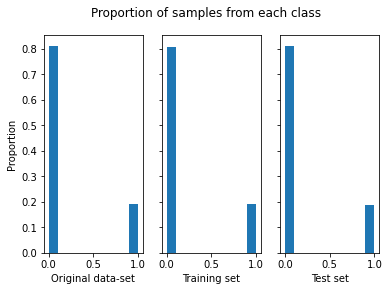

In [36]:
# Create training and test set
X_train, X_test, y_train, y_test = train_test_split(Xp, yp, test_size=0.3, random_state=42,stratify=yp)

fig, axs = plt.subplots(1, 3, sharey=True)
fig.suptitle('Proportion of samples from each class')
axs[0].hist(yp,weights=np.ones_like(yp)/len(yp))
axs[0].set_xlabel('Original data-set')
axs[1].hist(y_train,weights=np.ones_like(y_train)/len(y_train))
axs[1].set_xlabel('Training set')
axs[2].hist(y_test,weights=np.ones_like(y_test)/len(y_test))
axs[2].set_xlabel('Test set')
axs[0].set_ylabel('Proportion')

As we have already seen, it might be very important to scale the data such that each feature has, for instance, average equal to 0 and unit variance. Which is the right way of doing it when having a training and a test set in your opinion ? Should you use together both training and test set ?

**Answer:**
* The right way of doing it is that we apply the scaling to the train dataset and then apply the learned parameters to the test set. In fact, this ensures that we get the real performances of our model, not a biased performances.

In [37]:
# Scale data (each feature will have average equal to 0 and unit variance)
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train) 
X_test = scaler.transform(X_test)

Now, use two simple classification algorithms, for instance LDA and QDA, and look at the confusion matrices. 

**Question**: Comment the results. 

**Answer:**
* By applying the two simple classification algorithms on the scaled data, we had 82% accuracy with LDA and 84% accuracy with qda. At first sight we can say that the score is not too bad. but if we consider the confusion matrix in both cases, we can clearly see that we predict well the healthy individuals (more than 90% for both LDA and QDA).However, if we look to predictions of the unhealthy individuals, we can see that they are too low (41% for LDA and 42% for QDA).
* We can conclude that this model is too bad because we don't want our algorithm to classify an unhealthy person as healthy(more than 68% in the confusion matrix).

Fitting LDA to training set
              precision    recall  f1-score   support

           0       0.86      0.94      0.90       146
           1       0.55      0.32      0.41        34

    accuracy                           0.82       180
   macro avg       0.70      0.63      0.65       180
weighted avg       0.80      0.82      0.80       180

Normalized confusion matrix
[[0.93835616 0.06164384]
 [0.67647059 0.32352941]]


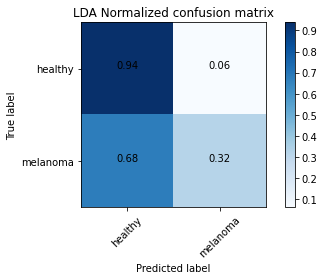

Fitting QDA to training set
              precision    recall  f1-score   support

           0       0.86      0.97      0.91       146
           1       0.71      0.29      0.42        34

    accuracy                           0.84       180
   macro avg       0.78      0.63      0.66       180
weighted avg       0.83      0.84      0.82       180

Normalized confusion matrix
[[0.97260274 0.02739726]
 [0.70588235 0.29411765]]


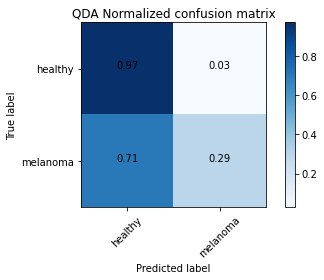

In [38]:
# Fitting LDA
print("Fitting LDA to training set")
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
y_pred = lda.predict(X_test)
print(classification_report(y_test, y_pred))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='LDA Normalized confusion matrix')
plt.show()

# Fitting QDA
print("Fitting QDA to training set")
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train, y_train)
y_pred_qda = qda.predict(X_test)
print(classification_report(y_test, y_pred_qda))
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_qda)
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='QDA Normalized confusion matrix')
plt.show()


The results you obtained are based on a precise subdivision of your data into training and test. This can thus bias your results. Which technique could you use instead ? Test it  with LDA, QDA and K-NN.

**Answer:** 
* In order to avoid biased results and generalize our model, it is intresting to consider using cross validation and then get the mean.

In [39]:
# Fitting LDA
print("Fitting LDA")
t0 = time()
lda = LinearDiscriminantAnalysis()
lda_score = cross_val_score(lda,X=Xp, y=np.ravel(yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(lda_score.mean(), lda_score.std() ))
# Fitting QDA
print("Fitting QDA")
t0 = time()
qda = QuadraticDiscriminantAnalysis()
qda_score = cross_val_score(qda,X=Xp, y=np.ravel(yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(qda_score.mean(), qda_score.std() ))

# Fitting K-nearest neighbour
t0 = time()
neigh = KNeighborsClassifier(n_neighbors=3)
neigh_score = cross_val_score(neigh,X=Xp, y=np.ravel(yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(neigh_score.mean(), neigh_score.std() ))

Fitting LDA
done in 0.035s
 Average and std CV score : 0.8116666666666665 +- 0.022730302828309745
Fitting QDA
done in 0.022s
 Average and std CV score : 0.7933333333333333 +- 0.03628590176179542
done in 0.052s
 Average and std CV score : 0.7816666666666666 +- 0.022607766610417544


When using K-NN, instead than fixing the number of nearest neighbours, we could also estimate the best value using Cross Validation. Do it and plot the confusion matrix. Do you notice anything strange ? Why in your opinion do you have this kind of result ?

**Answer:**
* The best value of K using Cross validation with K-NN is equal to 10. In fact, we obtained a score of 0.83.But if we consider the confusion matrix, it is like we have just assigned the class "healthy" to most individuals which is not logical.
* I think that we obtained such results because of the fact that we are using the accuracy as metric. In fact, in our problem we have  N= 600 and only 115 are unhealthy (19%). So assigning the label 0 most of the time will lead to high accuracy. This won't really show us how bad our model is. Maybe using another metric will ameliorate the results.

Best training Score: 0.8333333333333334
Best training params: {'n_neighbors': 10}
Normalized confusion matrix
[[0.95890411 0.04109589]
 [0.82352941 0.17647059]]


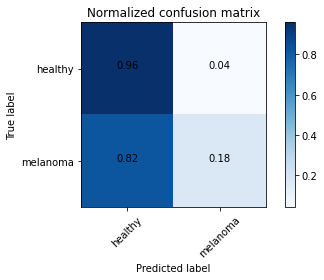

In [40]:
# Looking for the best hyperparameters
p_grid_KNN = {'n_neighbors': [1,2,3,4,5,6,7,8,9,10]}
KNN = KNeighborsClassifier()
grid_KNN = GridSearchCV(estimator=KNN, param_grid=p_grid_KNN, scoring="accuracy", cv=5)
grid_KNN.fit(X_train, y_train)
print("Best training Score: {}".format(grid_KNN.best_score_))
print("Best training params: {}".format(grid_KNN.best_params_))
y_pred = grid_KNN.predict(X_test)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In order to deal with this problem we have two possible solutions. 

**First**: Please look at this webpage (https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter) and try MORE APPROPRIATE scoring functions than accuracy when looking for the best K value of K-NN (thus within the Cross Validation as before..).

**Answer:**
* In this case, we want to minize the prediction errors of Flase Positive and False Negative. To do so, i decided to consider from the link provided the f1_score or the accuracy balanced metric (since here we have imbalanced data)
* The best K found with both methods is equal to 3.
* The TN percentage has increased from 18% to 35% but it is still not sufficient

Best training Score: 0.38629390681003584
Best training params: {'n_neighbors': 3}
Normalized confusion matrix
[[0.88356164 0.11643836]
 [0.64705882 0.35294118]]


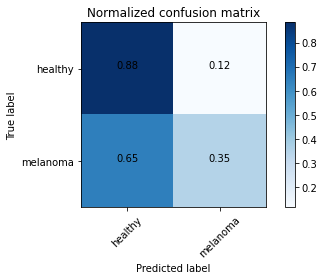

test set f1 score  0.38095238095238093


In [60]:
# Looking for the best hyperparameters
p_grid_KNN = {'n_neighbors': [1,2,3,4,5,6,7,8,9,10]}
KNN = KNeighborsClassifier()
grid_KNN = GridSearchCV(estimator=KNN, param_grid=p_grid_KNN, scoring="f1", cv=5)
grid_KNN.fit(X_train, y_train)
print("Best training Score: {}".format(grid_KNN.best_score_))
print("Best training params: {}".format(grid_KNN.best_params_))
y_pred = grid_KNN.predict(X_test)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()
print("test set f1 score ",f1_score(y_test,y_pred))

Best training Score: 0.6192877524143986
Best training params: {'n_neighbors': 3}
Normalized confusion matrix
[[0.88356164 0.11643836]
 [0.64705882 0.35294118]]


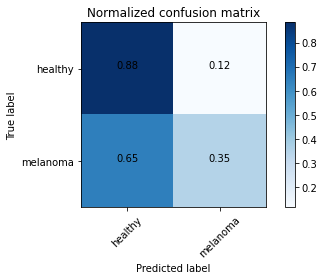

 the balanced accuracy on test dataset  0.6182514101531024


In [42]:
# Looking for the best hyperparameters
p_grid_KNN = {'n_neighbors': [1,2,3,4,5,6,7,8,9,10]}
KNN = KNeighborsClassifier()
grid_KNN = GridSearchCV(estimator=KNN, param_grid=p_grid_KNN, scoring="balanced_accuracy", cv=5)
grid_KNN.fit(X_train, y_train)
print("Best training Score: {}".format(grid_KNN.best_score_))
print("Best training params: {}".format(grid_KNN.best_params_))
y_pred = grid_KNN.predict(X_test)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()
print(" the balanced accuracy on test dataset ",balanced_accuracy_score(y_test,y_pred))

**Second**: when dealing with such a problem (the one you should find !) a possible solution would be to oversample a class (which one in your opinion ?) Please look at this web page for more information (https://imbalanced-learn.readthedocs.io/en/stable/over_sampling.html) and try at least one naive random over-sampling (look at the following code...).

**Answer:**
* In this case, we are dealing with imbalanced dataset. To overcome this problem, we could oversample the minority class (class 1 : unhealthy individuals)

In [43]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
print(sorted(Counter(y_resampled).items()))

[(0, 339), (1, 339)]


Let's look for the best K in KNN (as before using Cross validation) but this time on the new training set. 

**Question**: Are the results better ? Do they change now if you modify the scoring function ? Why ?

**Answer:**
* After applying the oversampling to the minority class, we obtained better results.
* The testing score has also incrased from 38% to 40% with the scoring function "f1" and from 61% to 63% for the "balanced accuracy".
* Yes, the results change with different scoring functions. In fact, the metric is an important parameter in the evaluation of our model.

Best training Score: 0.903332095278404
Best training params: {'n_neighbors': 1}
Normalized confusion matrix
[[0.85616438 0.14383562]
 [0.58823529 0.41176471]]


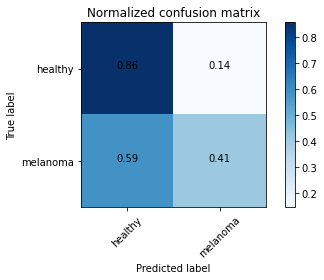

test set f1 score 0.40579710144927533


In [61]:
# Looking for the best hyperparameters
p_grid_KNN = {'n_neighbors': [1,2,3,4,5,6,7,8,9,10]}
KNN = KNeighborsClassifier()
grid_KNN = GridSearchCV(estimator=KNN, param_grid=p_grid_KNN, scoring="f1", cv=5)
grid_KNN.fit(X_resampled, y_resampled)
print("Best training Score: {}".format(grid_KNN.best_score_))
print("Best training params: {}".format(grid_KNN.best_params_))
y_pred = grid_KNN.predict(X_test)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()
print("test set f1 score",f1_score(y_test,y_pred))

Best training Score: 0.8937445127304653
Best training params: {'n_neighbors': 1}
Normalized confusion matrix
[[0.85616438 0.14383562]
 [0.58823529 0.41176471]]


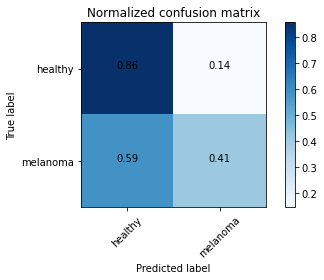

 the balanced accuracy on test dataset  0.6339645447219984


In [45]:
# Looking for the best hyperparameters
p_grid_KNN = {'n_neighbors': [1,2,3,4,5,6,7,8,9,10]}
KNN = KNeighborsClassifier()
grid_KNN = GridSearchCV(estimator=KNN, param_grid=p_grid_KNN, scoring="balanced_accuracy", cv=5)
grid_KNN.fit(X_resampled, y_resampled)
print("Best training Score: {}".format(grid_KNN.best_score_))
print("Best training params: {}".format(grid_KNN.best_params_))
y_pred = grid_KNN.predict(X_test)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()
print(" the balanced accuracy on test dataset ",balanced_accuracy_score(y_test,y_pred))

Let's use the techniques seen today: Perceptron and linear SVM. 

* Using "accuracy" as a scoring function :

In [46]:
# Fitting Perceptron
print("Fitting Perceptron")
Perc = Perceptron()
Perc_cv = cross_validate(Perc,Xp, yp,cv=5,scoring='accuracy',return_train_score=True)
print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Perc_cv['train_score'].mean(), Perc_cv['train_score'].std() ))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(Perc_cv['test_score'].mean(), Perc_cv['test_score'].std() ))


# Fitting linear SVM 
print("Fitting Linear SVM")
Lsvm = LinearSVC() 
Lsvm_cv = cross_validate(Lsvm,Xp, yp,cv=5,scoring='accuracy',return_train_score=True)
print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Lsvm_cv['train_score'].mean(), Lsvm_cv['train_score'].std() ))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(Lsvm_cv['test_score'].mean(), Lsvm_cv['test_score'].std() ))

Fitting Perceptron
 Average and std TRAIN CV accuracy : 0.6487499999999999 +- 0.12621355359513142
 Average and std TEST CV accuracy : 0.6433333333333333 +- 0.13574895129531492
Fitting Linear SVM
 Average and std TRAIN CV accuracy : 0.5729166666666667 +- 0.288596941155731
 Average and std TEST CV accuracy : 0.5733333333333334 +- 0.28840557861764354


We can easily use different scoring functions within the cross validate function of scikit-learn. Check the code.

* Using "accuracy" & "f1" as a scoring function :

In [47]:
# Fitting Perceptron
print("Fitting Perceptron")
Perc = Perceptron()
Perc_cv = cross_validate(Perc,Xp, yp,cv=5,scoring=('accuracy', 'f1'),return_train_score=True)
print(Perc_cv.keys())
print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Perc_cv['train_accuracy'].mean(), Perc_cv['train_accuracy'].std() ))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(Perc_cv['test_accuracy'].mean(), Perc_cv['test_accuracy'].std() ))
print(" Average and std TRAIN CV f1 : {0} +- {1}".format(Perc_cv['train_f1'].mean(), Perc_cv['train_f1'].std() ))
print(" Average and std TEST CV f1 : {0} +- {1}".format(Perc_cv['test_f1'].mean(), Perc_cv['test_f1'].std() ))


# Fitting linear SVM 
print("Fitting Linear SVM")
Lsvm = LinearSVC() 
Lsvm_cv = cross_validate(Lsvm,Xp, yp,cv=5,scoring=('accuracy', 'f1'),return_train_score=True)
print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Lsvm_cv['train_accuracy'].mean(), Lsvm_cv['train_accuracy'].std() ))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(Lsvm_cv['test_accuracy'].mean(), Lsvm_cv['test_accuracy'].std() ))
print(" Average and std TRAIN CV f1 : {0} +- {1}".format(Lsvm_cv['train_f1'].mean(), Lsvm_cv['train_f1'].std() ))
print(" Average and std TEST CV f1 : {0} +- {1}".format(Lsvm_cv['test_f1'].mean(), Lsvm_cv['test_f1'].std() ))


Fitting Perceptron
dict_keys(['fit_time', 'score_time', 'test_accuracy', 'train_accuracy', 'test_f1', 'train_f1'])
 Average and std TRAIN CV accuracy : 0.6487499999999999 +- 0.12621355359513142
 Average and std TEST CV accuracy : 0.6433333333333333 +- 0.13574895129531492
 Average and std TRAIN CV f1 : 0.3606555467256628 +- 0.029265257193635822
 Average and std TEST CV f1 : 0.34098316200483386 +- 0.049318371861815015
Fitting Linear SVM
 Average and std TRAIN CV accuracy : 0.8099999999999999 +- 0.003061862178478962
 Average and std TEST CV accuracy : 0.8099999999999999 +- 0.008164965809277232
 Average and std TRAIN CV f1 : 0.09907068289083261 +- 0.0731552877800772
 Average and std TEST CV f1 : 0.09308755760368663 +- 0.12738914317545433


**Question** Please do the same on the oversampled data and compare the results with the previous ones.

**Answer:**
* In the response to this question, i will especially concentrate on the results regarding the f1_score funtion.
* We can see that the Average and std TRAIN CV f1 of the perceptron and LinearSVM has passed from 36% (perceptron) / 9% (LinearSVM)
to 51% (perceptron) / 37% (LinearSVM) when we applied oversampling on the monority class
* We can see that the Average and std TEST CV f1 of the perceptron and LinearSVM has passed from 34% (perceptron) / 9% (LinearSVM)
to 51% (perceptron) / 32% (LinearSVM) when we applied oversampling on the monority class

* Using "accuracy" & "f1" as a scoring function :

In [48]:
X_resampled_All, y_resampled_All = ros.fit_resample(Xp, yp)

#X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled = train_test_split(X_resampled_All, y_resampled_All, test_size=0.3, random_state=42,stratify=yp)

# Fitting Perceptron
print("Fitting Perceptron")
Perc = Perceptron()
Perc_cv = cross_validate(Perc,X_resampled_All, y_resampled_All,cv=5,scoring=('accuracy', 'f1'),return_train_score=True)
print(Perc_cv.keys())
print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Perc_cv['train_accuracy'].mean(), Perc_cv['train_accuracy'].std() ))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(Perc_cv['test_accuracy'].mean(), Perc_cv['test_accuracy'].std() ))
print(" Average and std TRAIN CV f1 : {0} +- {1}".format(Perc_cv['train_f1'].mean(), Perc_cv['train_f1'].std() ))
print(" Average and std TEST CV f1 : {0} +- {1}".format(Perc_cv['test_f1'].mean(), Perc_cv['test_f1'].std() ))


# Fitting linear SVM 
print("Fitting Linear SVM")
Lsvm = LinearSVC() 
Lsvm_cv = cross_validate(Lsvm,X_resampled_All, y_resampled_All,cv=5,scoring=('accuracy', 'f1'),return_train_score=True)
print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Lsvm_cv['train_accuracy'].mean(), Lsvm_cv['train_accuracy'].std() ))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(Lsvm_cv['test_accuracy'].mean(), Lsvm_cv['test_accuracy'].std() ))
print(" Average and std TRAIN CV f1 : {0} +- {1}".format(Lsvm_cv['train_f1'].mean(), Lsvm_cv['train_f1'].std() ))
print(" Average and std TEST CV f1 : {0} +- {1}".format(Lsvm_cv['test_f1'].mean(), Lsvm_cv['test_f1'].std() ))


Fitting Perceptron
dict_keys(['fit_time', 'score_time', 'test_accuracy', 'train_accuracy', 'test_f1', 'train_f1'])
 Average and std TRAIN CV accuracy : 0.5713917525773196 +- 0.054133528810147324
 Average and std TEST CV accuracy : 0.5783505154639175 +- 0.055459701675516566
 Average and std TRAIN CV f1 : 0.5153728687752093 +- 0.2398551738461645
 Average and std TEST CV f1 : 0.5185685688800706 +- 0.23686498284399218
Fitting Linear SVM
 Average and std TRAIN CV accuracy : 0.5744845360824742 +- 0.059117891299841054
 Average and std TEST CV accuracy : 0.5432989690721649 +- 0.033021891501127776
 Average and std TRAIN CV f1 : 0.37156446816646355 +- 0.265935181280486
 Average and std TEST CV f1 : 0.32332391791579396 +- 0.2676444578993207


We can also ask to save the estimated models at each split (i.e. fold) with the option `return_estimator=True`. Using the perceptron, we will look for the best model using the oversampled training data and check the confusion matrix on the test data. 

**Question** Do it the same with the linear SVM.

Fitting Perceptron
dict_keys(['fit_time', 'score_time', 'estimator', 'test_accuracy', 'train_accuracy', 'test_f1', 'train_f1'])
 Average and std TRAIN CV accuracy : 0.6887892193839066 +- 0.036158057852955526
 Average and std TEST CV accuracy : 0.6563943355119826 +- 0.032892690337067695
 Average and std TRAIN CV f1 : 0.6935668537286211 +- 0.030220953336842066
 Average and std TEST CV f1 : 0.6644316320423254 +- 0.046478478723849206
Normalized confusion matrix
[[0.59589041 0.40410959]
 [0.47058824 0.52941176]]


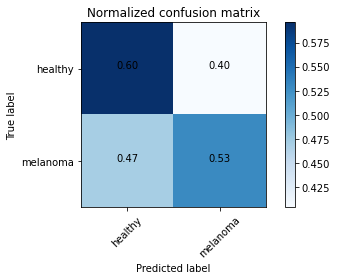

test f1-score 0.32432432432432434


In [62]:
# Fitting Perceptron
print("Fitting Perceptron")
Perc = Perceptron()
Perc_cv = cross_validate(Perc,X_resampled, y_resampled,cv=5,scoring=('accuracy', 'f1'),return_train_score=True,return_estimator=True)
print(Perc_cv.keys())
print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Perc_cv['train_accuracy'].mean(), Perc_cv['train_accuracy'].std() ))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(Perc_cv['test_accuracy'].mean(), Perc_cv['test_accuracy'].std() ))
print(" Average and std TRAIN CV f1 : {0} +- {1}".format(Perc_cv['train_f1'].mean(), Perc_cv['train_f1'].std() ))
print(" Average and std TEST CV f1 : {0} +- {1}".format(Perc_cv['test_f1'].mean(), Perc_cv['test_f1'].std() ))

# Look for the best estimator (the one with the greatest test accuracy)
index_best = np.argmax(Perc_cv['test_accuracy'])
estimator_best=Perc_cv['estimator'][index_best]
y_pred = estimator_best.predict(X_test)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()
print("test f1-score",f1_score(y_test,y_pred))


Fitting linear SVM 
dict_keys(['fit_time', 'score_time', 'estimator', 'test_accuracy', 'train_accuracy', 'test_f1', 'train_f1'])
 Average and std TRAIN CV accuracy : 0.5208762886597939 +- 0.030038767596563872
 Average and std TEST CV accuracy : 0.522680412371134 +- 0.040403954520134885
 Average and std TRAIN CV f1 : 0.3480070609301397 +- 0.3014379331923549
 Average and std TEST CV f1 : 0.34728039158675045 +- 0.29945309248066115
Normalized confusion matrix
[[0.69178082 0.30821918]
 [0.38235294 0.61764706]]


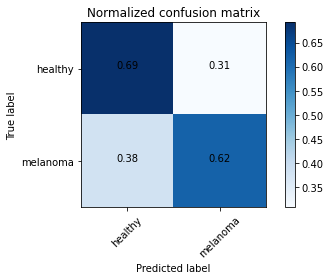

test set f1 score  0.42000000000000004


In [63]:
# Fitting linear SVM 
print("Fitting linear SVM ")
Lsvm = LinearSVC() 
Lsvm_cv = cross_validate(Lsvm,X_resampled_All, y_resampled_All,cv=5,scoring=('accuracy', 'f1'),return_train_score=True,return_estimator=True)
print(Lsvm_cv.keys())
print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Lsvm_cv['train_accuracy'].mean(), Lsvm_cv['train_accuracy'].std() ))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(Lsvm_cv['test_accuracy'].mean(), Lsvm_cv['test_accuracy'].std() ))
print(" Average and std TRAIN CV f1 : {0} +- {1}".format(Lsvm_cv['train_f1'].mean(), Lsvm_cv['train_f1'].std() ))
print(" Average and std TEST CV f1 : {0} +- {1}".format(Lsvm_cv['test_f1'].mean(), Lsvm_cv['test_f1'].std() ))
# Look for the best estimator (the one with the greatest test accuracy)
index_best = np.argmax(Lsvm_cv['test_accuracy'])
estimator_best=Lsvm_cv['estimator'][index_best]
y_pred = estimator_best.predict(X_test)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()
print("test set f1 score ",f1_score(y_test,y_pred))

Suppose that there are overlapping classes, we need to set the hyper-parameter C for the SVM model. 

**Question** Use Cross-Validation on the oversampled data to find the best C value. Plot the confusion matrix using the best estimator (as before).

**Answer**:
* while using CV on the oversampled data and with the parameter C ( controls the softness of the margin),We can see that the result of the test score has increased. It passed from 42% to 71% . We passed only to 24% of false negative,which is way better.

In [51]:
# Spliting the oversampled data 
X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled = train_test_split(X_resampled_All, y_resampled_All, test_size=0.3, random_state=42,stratify=y_resampled_All)


Best training Score: 0.6173107487509111
Best training params: {'C': 5}
Normalized confusion matrix
[[0.39041096 0.60958904]
 [0.09655172 0.90344828]]


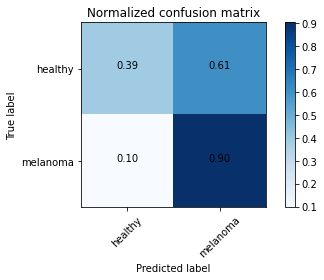

test set f1 score 0.7178082191780821


In [64]:
# Looking for the best hyperparameter C 
p_grid_lsvm = {'C': [1e-3,1e-2,1e-1,1,2,3,4,5,6,7,8,9,1e1]}
Lsvm = LinearSVC()
grid_lsvm = GridSearchCV(estimator=Lsvm, param_grid=p_grid_lsvm, scoring="f1", cv=5)
#grid_lsvm contain the best estimator
grid_lsvm.fit(X_train_resampled, y_train_resampled)
print("Best training Score: {}".format(grid_lsvm.best_score_))
print("Best training params: {}".format(grid_lsvm.best_params_))
y_pred = grid_lsvm.predict(X_test_resampled)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test_resampled, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()
print("test set f1 score",f1_score(y_test_resampled,y_pred))

Here it is the code for non-linear SVM using radial basis function. We need to tune another hyper-parameter $gamma$. We look for the best $C$ and $gamma$ at the same time.

**Question** Use Cross-Validation on the oversampled data to find the best C and $gamma$ value. Plot the confusion matrix using the best estimator (as before).

Fitting Non-linear SVM to the training set
Best training Score: 0.9587581699346405
Best training params: {'C': 1, 'gamma': 0.005}
Normalized confusion matrix
[[1.         0.        ]
 [0.02758621 0.97241379]]


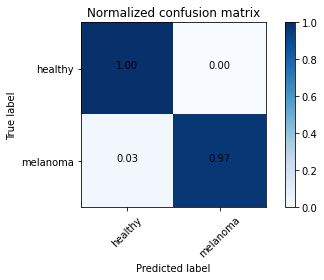

test set f1 score 0.9860139860139859


In [65]:
# Fitting Non-linear SVM
print("Fitting Non-linear SVM to the training set")
t0 = time()
p_grid_nlsvm = {'C': [1e-3,1e-2,1e-1,1,2,3,4,5,6,7,8,9,1e1],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1] }
NLsvm = SVC(kernel='rbf')
grid_nlsvm = GridSearchCV(estimator=NLsvm, param_grid=p_grid_nlsvm, scoring="accuracy", cv=5)
#grid_nlsvm contain the best estimator
grid_nlsvm.fit(X_train_resampled, y_train_resampled)
print("Best training Score: {}".format(grid_nlsvm.best_score_))
print("Best training params: {}".format(grid_nlsvm.best_params_))
y_pred = grid_nlsvm.predict(X_test_resampled)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test_resampled, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()
print("test set f1 score",f1_score(y_test_resampled,y_pred))

**Answer:**
* For a medical use, we have perfect results.In fact, for C=1 and gamma =0,005, we have a really hight percentage of TN & TP. 
* We can see a score of 98% on test data too.

**Question** Use the non-linear SVM with the two strategies seen before (different scoring function and/or oversampled data). Do the results change ? Why in your opinion ?

##**Different scoring function**

* Working with the f1_score instead of the accuracy helped us to improve the results of the classifier. in fact, while considering the original data, we can see that the f1 score for test data passed from 25%(score with accuracy) to 44% and the percentage of TN is quite higher.
* The amelioration of the performances is quite logical since here we work with a more accurate metric and we are using cross validation

###Using the Accuracy

Fitting Non-linear SVM to the training set
Best training Score: 0.8333333333333334
Best training params: {'C': 2, 'gamma': 0.01}
Normalized confusion matrix
[[0.99315068 0.00684932]
 [0.85294118 0.14705882]]


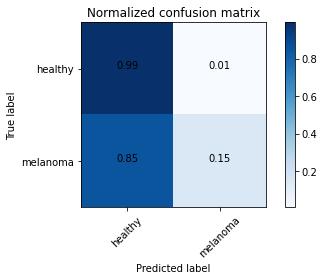

test set f1 score 0.25


In [66]:
# Fitting Non-linear SVM
print("Fitting Non-linear SVM to the training set")
t0 = time()
p_grid_nlsvm = {'C': [1e-3,1e-2,1e-1,1,2,3,4,5,6,7,8,9,1e1,20,23,50,100],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
NLsvm = SVC(kernel='rbf')
grid_nlsvm = GridSearchCV(estimator=NLsvm, param_grid=p_grid_nlsvm, scoring="accuracy", cv=5)

#grid_nlsvm contain the best estimator
grid_nlsvm.fit(X_train, y_train)
print("Best training Score: {}".format(grid_nlsvm.best_score_))
print("Best training params: {}".format(grid_nlsvm.best_params_))
y_pred = grid_nlsvm.predict(X_test)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()
print("test set f1 score",f1_score(y_test,y_pred))

###Using the f1_score 

Fitting Non-linear SVM to the training set
Best training Score: 0.5078494940563906
Best training params: {'C': 100, 'gamma': 0.01}
Normalized confusion matrix
[[0.84931507 0.15068493]
 [0.52941176 0.47058824]]


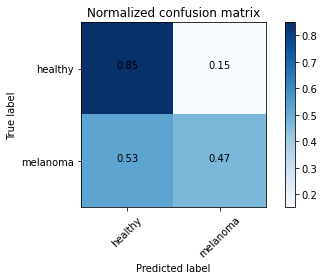

test set f1 score 0.4444444444444444


In [67]:
# Fitting Non-linear SVM
print("Fitting Non-linear SVM to the training set")
t0 = time()
p_grid_nlsvm = {'C': [1e-3,1e-2,1e-1,1,2,3,4,5,6,7,8,9,1e1,20,23,50,100],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
NLsvm = SVC(kernel='rbf')
grid_nlsvm = GridSearchCV(estimator=NLsvm, param_grid=p_grid_nlsvm, scoring="f1", cv=5)

#grid_nlsvm contain the best estimator
grid_nlsvm.fit(X_train, y_train)
print("Best training Score: {}".format(grid_nlsvm.best_score_))
print("Best training params: {}".format(grid_nlsvm.best_params_))
y_pred = grid_nlsvm.predict(X_test)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()
print("test set f1 score",f1_score(y_test,y_pred))

##**Oversampled data**

**Answer**:
* After oversampling the data, the best parameter C we got is 1 and the best gamma value of the gaussian kernel is 0.001.
* We can see that the f1 score on test data went from 44% to 98% when we oversampled which is quite satisfying.

Fitting Non-linear SVM to the training set
Best training Score: 0.9567933489359101
Best training params: {'C': 1, 'gamma': 0.005}
Normalized confusion matrix
[[1.         0.        ]
 [0.02758621 0.97241379]]


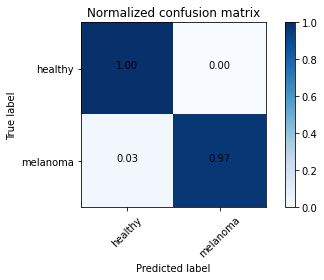

test set f1 score 0.9860139860139859


In [68]:
# Fitting Non-linear SVM
print("Fitting Non-linear SVM to the training set")
t0 = time()
p_grid_nlsvm = {'C': [1e-3,1e-2,1e-1,1,2,3,4,5,6,7,8,9,1e1,20,30,50,100],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
NLsvm = SVC(kernel='rbf')
grid_nlsvm = GridSearchCV(estimator=NLsvm, param_grid=p_grid_nlsvm, scoring="f1", cv=5)

#grid_nlsvm contain the best estimator
grid_nlsvm.fit(X_train_resampled, y_train_resampled)
print("Best training Score: {}".format(grid_nlsvm.best_score_))
print("Best training params: {}".format(grid_nlsvm.best_params_))
y_pred = grid_nlsvm.predict(X_test_resampled)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test_resampled, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()
print("test set f1 score",f1_score(y_test_resampled,y_pred))

**Question** Try to draw a conclusion from the different experiments. Which is the best method ? Which scoring function should you use ? Is it worth it to oversample one of the two classes ?

**Answer:**
* In conclusion, we can see in our case that the Non linear SVM gave way better results than Linear SVM.
* While considering the f1_score as a metric, we can see that we reached a score of 98% when we worked with the oversampled data and balanced our data.Moreover, the confusion matrix show high percentages for the TP & TN.
* The scoring function we should use in our case is the f1-score i think since we started to work with imbalanced data. As mentioned earlier in the tp the accuracy could give scores that don't reflect how bad the model is
* Yes, definately. When we oversampled the minority class,we had way better results.

**OPTIONAL** Another interesting question is: what about the number of features ? Can we reduce the dimensionality ? You could use one of the techniques seen during the previous lectures (i.e. PCA) ...

**Answer:** we will use the PCA technique

In [26]:
# Test PCA with a linear SVM
from sklearn.decomposition import PCA
pca = PCA(random_state=1,n_components=0.99) # taking the features that explain 99% of the variability of the data
# We will fit and transforme the train dataset 
X_train_pca  = pca.fit_transform(X_train)
# We will apply the fitted pca on the test dataset.
X_test_pca = pca.transform(X_test)



 Using the PCA to select the most imortant features 
Best training Score: 0.4205860805860806
Best training params: {'C': 0.001}
Normalized confusion matrix
[[0.93835616 0.06164384]
 [0.67647059 0.32352941]]


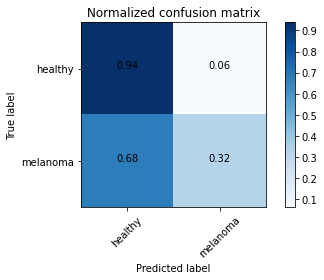

test set f1 score 0.4074074074074075


In [69]:
# Fitting Linear SVM 
# Looking for the best hyperparameter C 
print(" Using the PCA to select the most imortant features ")
p_grid_lsvm = {'C': [1e-3,1e-2,1e-1,1,2,3,4,5,6,7,8,9,1e1]}
Lsvm = LinearSVC()
grid_lsvm = GridSearchCV(estimator=Lsvm, param_grid=p_grid_lsvm, scoring="f1", cv=5)
#grid_lsvm contain the best estimator
grid_lsvm.fit(X_train_pca ,y_train)
print("Best training Score: {}".format(grid_lsvm.best_score_))
print("Best training params: {}".format(grid_lsvm.best_params_))
y_pred = grid_lsvm.predict(X_test_pca)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()
print("test set f1 score",f1_score(y_test,y_pred))

Fitting Non-linear SVM to the training set
Best training Score: 0.4607902086162956
Best training params: {'C': 30, 'gamma': 0.01}
Normalized confusion matrix
[[0.94520548 0.05479452]
 [0.79411765 0.20588235]]


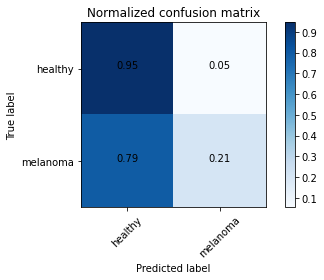

test set f1 score 0.28571428571428564


In [70]:
# Fitting Non-linear SVM
print("Fitting Non-linear SVM to the training set")
t0 = time()
p_grid_nlsvm = {'C': [1e-3,1e-2,1e-1,1,2,3,4,5,6,7,8,9,1e1,20,30,50,100],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
NLsvm = SVC(kernel='rbf')
grid_nlsvm = GridSearchCV(estimator=NLsvm, param_grid=p_grid_nlsvm, scoring="f1", cv=5)

#grid_nlsvm contain the best estimator
grid_nlsvm.fit(X_train_pca ,y_train)
print("Best training Score: {}".format(grid_nlsvm.best_score_))
print("Best training params: {}".format(grid_nlsvm.best_params_))
y_pred = grid_nlsvm.predict(X_test_pca)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()
print("test set f1 score",f1_score(y_test,y_pred))

**OPTIONAL** ... or test the importance of the single features.
The more naive technique would be to test each feature independently in a greedy fashion called sequential forward feature selection. Starting from an empty set and a classification model, you will first add the feature that maximizes a certain criterion (i.e. f1 score). Then, you will iterate this process until a chosen stopping criterion by adding at each iteration only the best feature. Each feature can be added of course only once. You could also use the opposite process by removing at each iteraton the least important feature starting from the entire set of features (i.e. sequential backward feature selection). Implement at least one of these ideas. 